In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)
with tf.device(device_name):
  pass

/device:GPU:0


In [14]:
import numpy,cv2
import matplotlib.pyplot as plt
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Conv2D,MaxPool2D,UpSampling2D,Rescaling,Activation,BatchNormalization,Subtract
from keras.datasets import mnist
plt.rcParams["figure.figsize"] = (10,10)

In [15]:
temp_data = numpy.load("/content/drive/MyDrive/Noise Data Cleaning/train_cleaned.npz",allow_pickle=True)
temp_data = temp_data['arr_0']

print(temp_data[0].shape)

(420, 540, 3)


(144, 420, 540, 3)



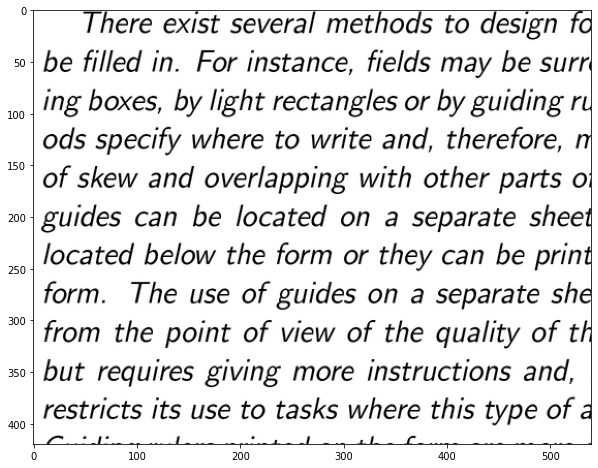

In [16]:
train_cleaned_data = numpy.load("/content/drive/MyDrive/Noise Data Cleaning/train_cleaned.npz",allow_pickle=True)
train_cleaned_data = train_cleaned_data['arr_0']

train_cleaned_data = [cv2.resize(train_cleaned_data[i], (540, 420), interpolation = cv2.INTER_AREA) for i in range(train_cleaned_data.shape[0])]
train_cleaned_data = numpy.array(train_cleaned_data)
print(train_cleaned_data.shape)
print()


plt.imshow(train_cleaned_data[0])
# show the plot
plt.show()

(144, 420, 540, 3)



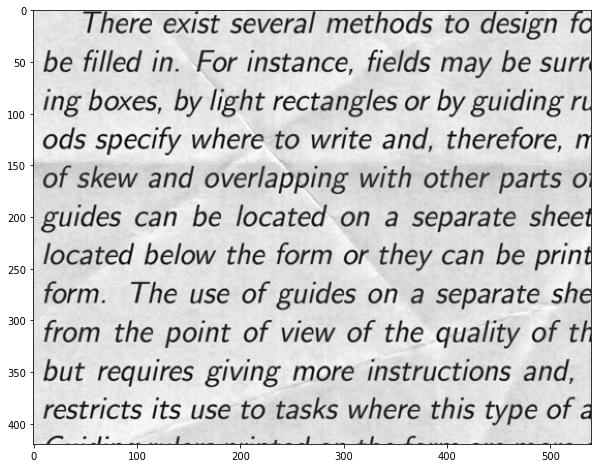

In [17]:
train_data = numpy.load("/content/drive/MyDrive/Noise Data Cleaning/train.npz",allow_pickle=True)
train_data = train_data['arr_0']

train_data = [cv2.resize(train_data[i], (540, 420), interpolation = cv2.INTER_AREA) for i in range(train_data.shape[0])]
train_data = numpy.array(train_data)
print(train_data.shape)
print()


plt.imshow(train_data[0])
# show the plot
plt.show()

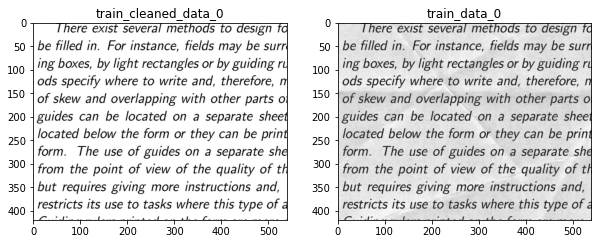

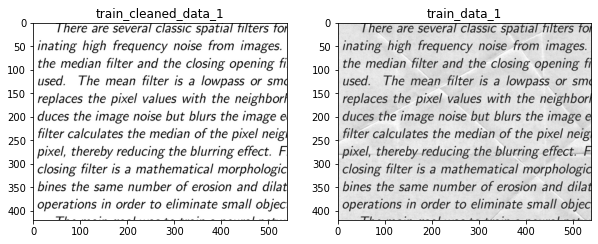

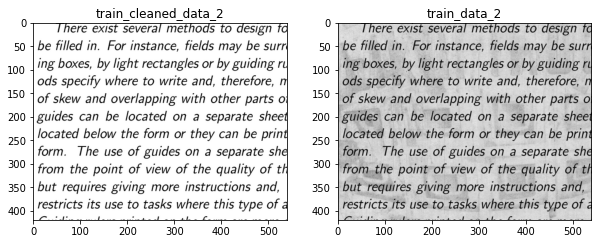

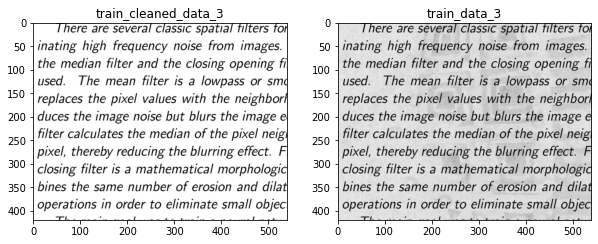

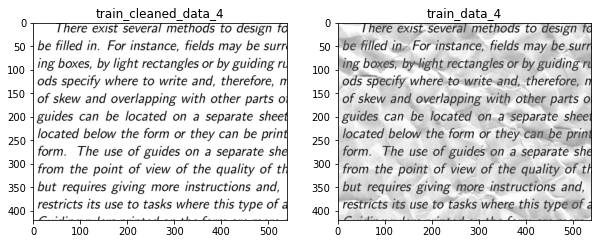

In [18]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(5):
  plt.subplot(221)
  plt.imshow(train_cleaned_data[i])
  plt.title('train_cleaned_data_'+str(i))
  plt.subplot(222)
  plt.imshow(train_data[i])
  plt.title('train_data_'+str(i))
  plt.show()

(72, 420, 540, 3)



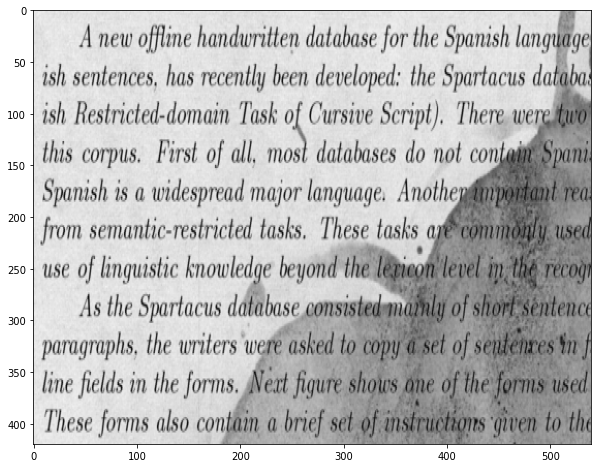

In [19]:
test_data = numpy.load("/content/drive/MyDrive/Noise Data Cleaning/test.npz",allow_pickle=True)
test_data = test_data['arr_0']

test_data = [cv2.resize(test_data[i], (540, 420), interpolation = cv2.INTER_AREA) for i in range(test_data.shape[0])]
test_data = numpy.array(test_data)
print(test_data.shape)
print()

plt.imshow(test_data[0])
# show the plot
plt.show()

In [20]:
train_cleaned_data = train_cleaned_data / 255
train_data = train_data / 255
test_data = test_data / 255

In [21]:
# def model(input_shape=(420, 540, 3)):
#   input=Input(input_shape)
#   x = Rescaling(1.0 / 255)(input)
#   x=Conv2D(164,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=MaxPool2D()(x)
#   x=Conv2D(164,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=MaxPool2D()(x)
#   x=Conv2D(264,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=MaxPool2D()(x)
#   x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=MaxPool2D()(x)
#   x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=UpSampling2D()(x)
#   x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=UpSampling2D()(x)
#   x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=UpSampling2D()(x)
#   x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=UpSampling2D()(x)
#   x=Conv2D(3,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)
#   x=Conv2D(3,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same')(x)

#   model=Model(input,x)

#   return model

# model = model()
# model.summary()

In [22]:
def DnCNN(input_shape=(420, 540, 3)):
    input = Input(shape=input_shape,name='input')
    x = Conv2D(32,kernel_size= (3,3), padding='same',name='conv2d_l1')(input)
    x = Activation('relu',name='act_l1')(x)
    for i in range(12):
        x = Conv2D(32, kernel_size=(3,3), padding='same',name='conv2d_'+str(i))(x)
        x = BatchNormalization(axis=-1,name='BN_'+str(i))(x)
        x = Activation('relu',name='act_'+str(i))(x)   
    x = Conv2D(3, kernel_size=(3,3), padding='same',name='conv2d_l3')(x)
    x = Subtract(name='subtract')([input, x])   
    model = Model(input,x)
    
    return model
model = DnCNN()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 420, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_l1 (Conv2D)             (None, 420, 540, 32  896         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 act_l1 (Activation)            (None, 420, 540, 32  0           ['conv2d_l1[0][0]']              
                                )                                                           

In [23]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
# Training model
batch_size = 5
epochs = 20
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
with tf.device(device_name):
  model.fit(train_data, train_cleaned_data, callbacks=callbacks, validation_data = (train_data, train_cleaned_data), epochs=epochs, batch_size=batch_size)  # validation_data=(x_test_noisy, X_test)

Epoch 1/20
29/29 [==============================] - 61s 2s/step - loss: 0.1751 - val_loss: 0.0146
Epoch 2/20
29/29 [==============================] - 45s 2s/step - loss: 0.0112 - val_loss: 0.0111
Epoch 3/20
29/29 [==============================] - 45s 2s/step - loss: 0.0085 - val_loss: 0.0108
Epoch 4/20
29/29 [==============================] - 45s 2s/step - loss: 0.0065 - val_loss: 0.0096
Epoch 5/20
29/29 [==============================] - 45s 2s/step - loss: 0.0060 - val_loss: 0.0105
Epoch 6/20
29/29 [==============================] - 45s 2s/step - loss: 0.0054 - val_loss: 0.0095
Epoch 7/20
29/29 [==============================] - 45s 2s/step - loss: 0.0054 - val_loss: 0.0093
Epoch 8/20
29/29 [==============================] - 45s 2s/step - loss: 0.0051 - val_loss: 0.0091
Epoch 9/20
29/29 [==============================] - 45s 2s/step - loss: 0.0049 - val_loss: 0.0091
Epoch 10/20
29/29 [==============================] - 45s 2s/step - loss: 0.0042 - val_loss: 0.0098
Epoch 11/20
29/29 [

In [25]:
# Final evaluation of the model
pred_data = model.predict(test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


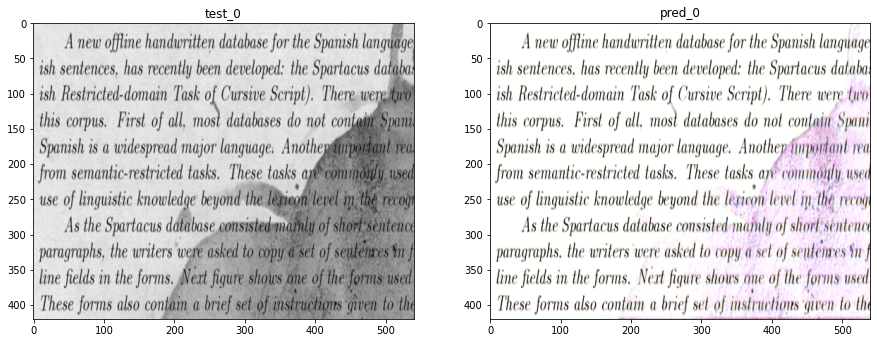

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


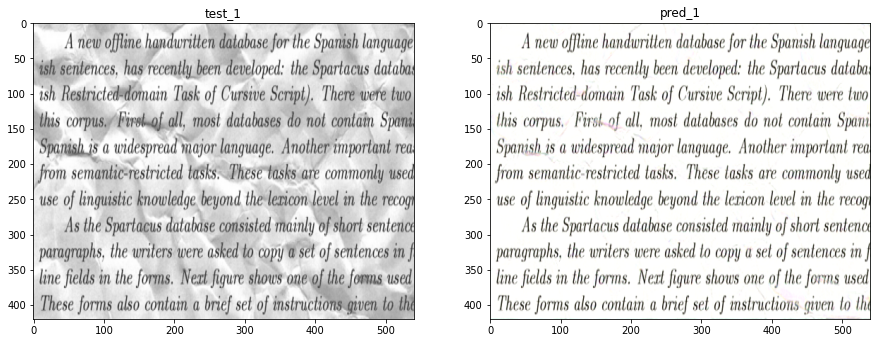

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


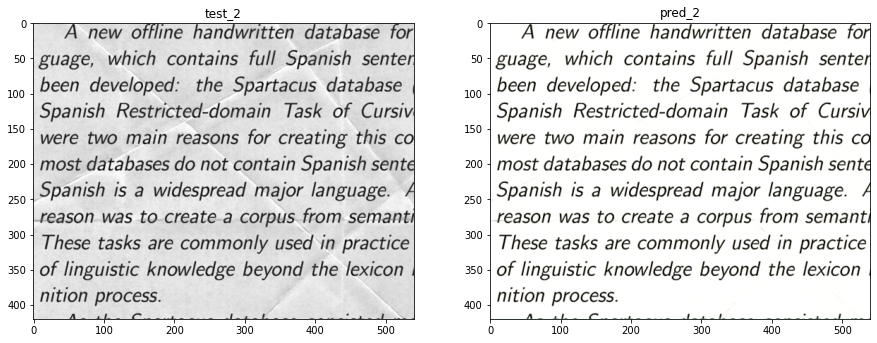

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


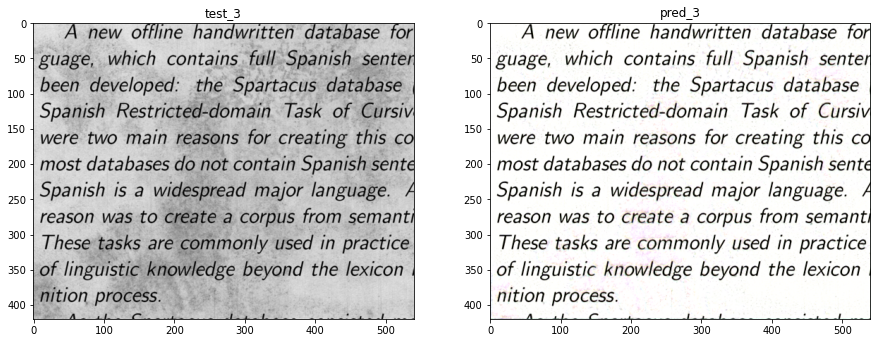

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


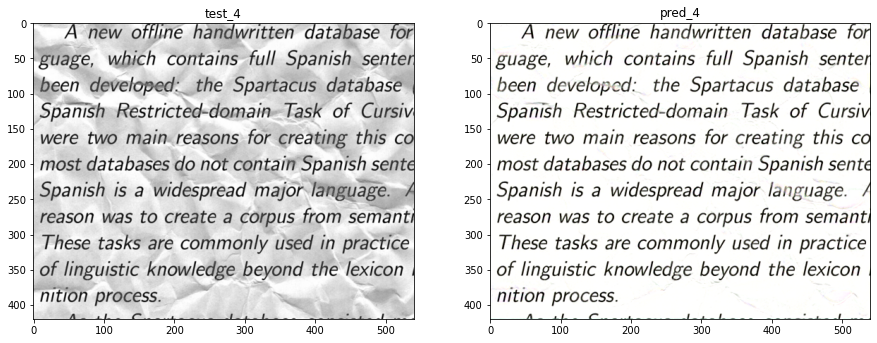

In [26]:
test = numpy.reshape(test_data, (72, 420, 540, 3))
pred = numpy.reshape(pred_data, (72, 420, 540, 3))

plt.rcParams["figure.figsize"] = (15,15)
for i in range(5):
  plt.subplot(221)
  plt.imshow(test[i])
  plt.title('test_'+str(i))
  plt.subplot(222)
  plt.imshow(pred[i])
  plt.title('pred_'+str(i))
  plt.show()